In [5]:
from tqdm import tqdm       #Para generar la barra que indica el progreso del loop.
import numpy as np
import Lorenz_63.Lorenz_63 as model
import Lorenz_63.Lorenz_63_DA as da

In [9]:
#Seleccionar aqui el operador de las observaciones que se desea usar.
from Lorenz_63.Lorenz_63_ObsOperator import forward_operator_full    as forward_operator
from Lorenz_63.Lorenz_63_ObsOperator import forward_operator_full_tl as forward_operator_tl

In [10]:
# Configuracion del sistema del modelo y del sistema de asimilacion.
da_exp=dict()  #Este diccionario va a contener las variables importantes para nuestro experimento.

da_exp['exp_id']='OI_xyz'    #Este es un identificador que se agregara al nombre de los archivos generados por este script (figuras, pickle contiendo los datos, etc)
da_exp['main_path']='./' + da_exp['exp_id']

#----------------------------------------------------------------------
# Creamos los directorios donde se guardaran los datos del experimento
#----------------------------------------------------------------------
    
da.directory_init( da_exp )

In [11]:
#------------------------------------------------------------
# Especificamos los parametros que usara el modelo
#------------------------------------------------------------

a      = 10.0      # standard L63 10.0 
r      = 28.0      # standard L63 28.0
b      = 8.0/3.0   # standard L63 8.0/3.0

da_exp['p']=np.array([a,r,b])

In [12]:
#------------------------------------------------------------
# Model and experienet setup
#------------------------------------------------------------

da_exp['dt']=0.01            # Paso de tiempo para la integracion del modelo de Lorenz
da_exp['numstep']=2000       # Cantidad de ciclos de asimilacion.
da_exp['x0']=np.array([ 8.0 , 0.0 , 30.0 ])      # Condiciones iniciales para el spin-up del nature run (no cambiar)
da_exp['numtrans']=600                           # Tiempo de spin-up para generar el nature run (no cambiar)

In [13]:
#------------------------------------------------------------
# Configuracion del sistema de asimilacion
#------------------------------------------------------------

da_exp['R0']=2.0                                    # Varianza del error de las observaciones.
da_exp['bst']=8                                     # Cantidad de pasos de tiempo entre 2 asimilaciones.
da_exp['forecast_length'] = 20                      # Plazo de pronostico (debe ser al menos 1)
da_exp['nvars']=3                                   # Numero de variables en el modelo de Lorenz (no tocar)

#Obtengo el numero de observaciones (lo obtengo directamente del forward operator)
da_exp['nobs']=np.shape(forward_operator(np.array([0,0,0])))[0]

#Definimos una matriz de error de las observaciones
da_exp['R']=da_exp['R0']*np.identity(da_exp['nobs'])   #En esta formulacion asumimos que los errores 
                                                       #en diferentes observaciones son todos iguales y 
#Creamos un vector de bias para las observaciones.
da_exp['obs_bias']=np.zeros(da_exp['nobs'])            #que no estan correlacionados entre si.

da_exp['P_from_file']=False                             #Si vamos a leer la matriz P de un archivo.
da_exp['P_to_file']=True                               #Si vamos a estimar y guardar la matriz P a partir de los pronosticos.

#P=np.array([[0.6 , 0.5 , 0.0 ],[0.5 , 0.6 , 0.0 ],[0.0 , 0.0 , 1.0 ]])
P=None

In [14]:
#------------------------------------------------------------
# Generamos la simulacion "verdad"
#------------------------------------------------------------

# Generamos la verdadera evolucion del sistema ("nature run")
# Integramos el modelo durante varios pasos de tiempo para que la solucion converja al atractor.

x=np.copy(da_exp['x0'])
for i in range(da_exp['numtrans'])  :
    x = model.forward_model( x , da_exp['p'] , da_exp['dt'] )
    
# Integramos la simulacion verdad
# El resultado es almacenado en un array de numpy "state" con dimension (numstep,3)

da_exp['state']=np.zeros((da_exp['numstep'],da_exp['nvars']))

for i  in range( da_exp['numstep'] ) :
    for j in range( da_exp['bst'] )      :
        x = model.forward_model( x , da_exp['p'] , da_exp['dt'] )
      
    da_exp['state'][i,:]=x

In [15]:
#------------------------------------------------------------
# Simulamos las observaciones y generamos las matrices que necesitamos
# para la asimilacion
#------------------------------------------------------------

# Simulamos las observaciones 

# initialize the matrix operator for data assimilation
da_exp = da.gen_obs( forward_operator , da_exp )

da_exp = da.get_P( da_exp , P )

Estimamos P a partir del nature run
La matriz que vamos a usar es:
[[ 0.62631423  0.62611912 -0.2268143 ]
 [ 0.62611912  0.81368816 -0.22323463]
 [-0.2268143  -0.22323463  6.27924948]]


In [16]:
#------------------------------------------------------------
# Corremos el ciclo de asimilacion
#------------------------------------------------------------

#Simulamos N ciclos de asimilacion en los cuales se asimilan las observaciones simuladas

#Iniciamos el ciclo de asimilacion

#Creamos el array que contiene a los analisis
da_exp['statea'] = np.zeros((da_exp['numstep'],da_exp['nvars']))
#Creamos el array que contiene a los pronosticos
da_exp['statef'] = np.zeros((da_exp['numstep'],da_exp['nvars'],da_exp['forecast_length'])) + np.nan

#Guardamos el P que utilizamos en cada ciclo de asimilacion y el Pa que obtenemos como resultado del 
#analisis
da_exp['P']= np.zeros((da_exp['state'].shape[0],da_exp['state'].shape[1],da_exp['state'].shape[1]))
da_exp['Pa']=np.zeros(np.shape(da_exp['P']))

#Guardamos la distancia entre el pronostico y las observaciones y entre el analisis y las observaciones
#para cada tiempo

da_exp['OmB']=np.zeros((da_exp['state'].shape[0],da_exp['yobs'].shape[1]))
da_exp['OmA']=np.zeros((da_exp['state'].shape[0],da_exp['yobs'].shape[1]))

#Inicializamos el ciclo desde la media "climatologica" del sistema. Es decir no tenemos informacion precisa
#de donde esta el sistema al tiempo inicial.
da_exp['statea'][0,:]= np.nanmean( da_exp['state'] , 0 )

for i in tqdm( range(1,da_exp['numstep']) ) :

    x=da_exp['statea'][i-1,:]
    #Vamos a hacer el pronostico de x con el modelo no lineal y el
    #pronostico de la covarianza con el tangente lineal y el adjunto.
    #Integrate the forward non-linear model to obtain the first-guess
       
    for k in range(da_exp['forecast_length']) :
        for j in range(da_exp['bst'])  :
            x = model.forward_model( x , da_exp['p'] , da_exp['dt'] )
        if ( i + k < da_exp['numstep'] ) :  #Solo para cerciorarme de que el pronostico no queda fuera del rango del experimento.
            da_exp['statef'][i+k,:,k]=x

    #Data assimilation 
    da_exp['P'][i,:,:] = da_exp['P0'] #En este metodo la matriz P se asume independiente del tiempo.

    [ da_exp['statea'][i,:] , da_exp['Pa'][i,:,:] , da_exp['OmB'][i,:] , da_exp['OmA'][i,:] ]=da.analysis_update(da_exp['yobs'][i,:],da_exp['statef'][i,:,0],da_exp['P0'],forward_operator,forward_operator_tl,da_exp['R']);

100%|██████████| 1999/1999 [00:06<00:00, 313.27it/s]


In [17]:
#------------------------------------------------------------
# Verificacion del ciclo de los resultados
#------------------------------------------------------------

#Calculamos los errores excluyendo los primeros spin_up ciclos de asimilacion.
    
da_exp = da.analysis_verification( forward_operator , da_exp ) #Calculamos el RMSE y BIAS del analisis.

()
()
('Analysis RMSE: ', array([0.60579288, 0.9742155 , 1.11280803]))
('First guess RMSE: ', array([0.82646107, 1.32376137, 1.29641267]))
('Obaservations RMSE: ', array([1.38950968, 1.43893069, 1.41074427]))
()
()
('Analysis BIAS: ', array([0.04189203, 0.06955561, 0.02111492]))
('First guess BIAS: ', array([0.06842225, 0.105351  , 0.07516767]))
('Observations BIAS: ', array([ 0.0481173 , -0.02883897,  0.00062544]))
()
()


Evolucion de la variable del analisis, el first guess, el nature run y las observaciones
Evolucion de la variable del analisis, el first guess, el nature run y las observaciones
Evolucion del error del analisis, el first guess, el nature run y las observaciones
Evolucion temporal del RMSE
Evolucion del RMSE y bias del pronostico con el plazo de pronostico


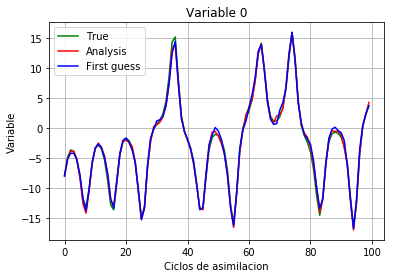

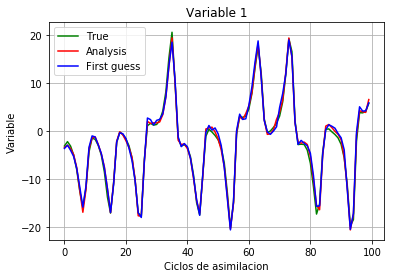

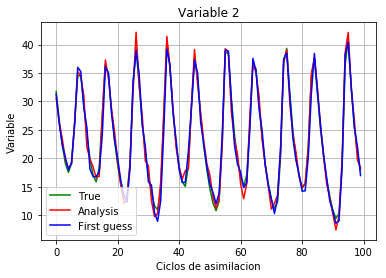

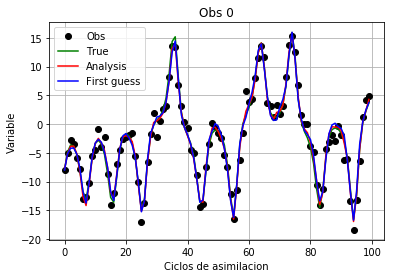

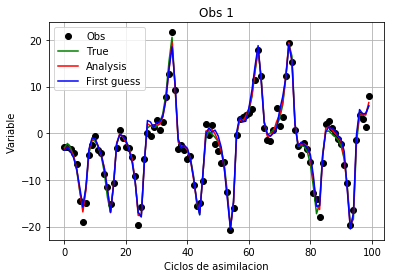

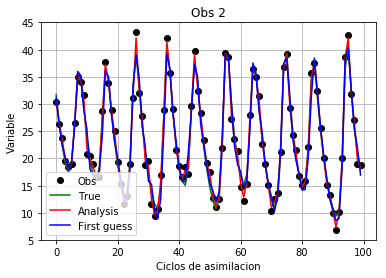

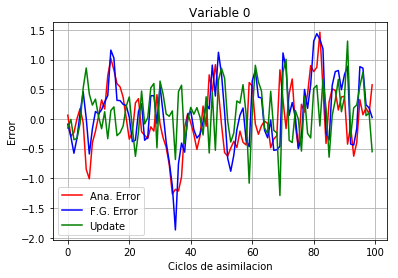

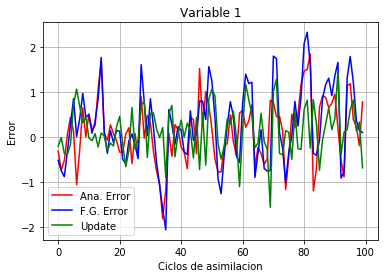

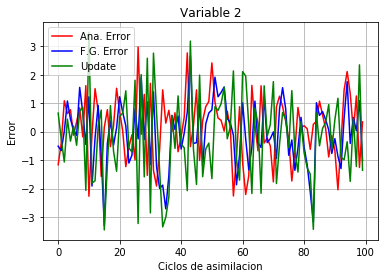

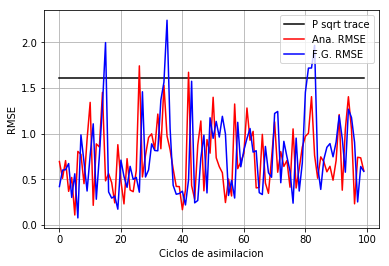

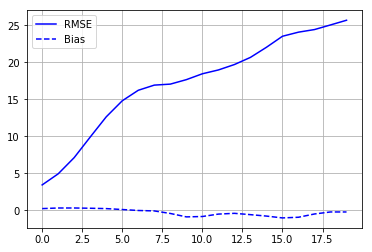

In [20]:
#------------------------------------------------------------
# Graficado 
#------------------------------------------------------------

#Graficos

#Graficamos la evolucion verdadera del sistema en 3D.
da.state_plot( da_exp )

#Graficamos la evolucion del estado verdadero, del first guess y del analisis
da.state_evolution( da_exp , 1000 , 1100 )  

#Graficamos la evolucion del sistema en el espacio de las obs para el first guess, el analisis y las observaciones
da.obs_evolution( da_exp , 1000 , 1100 , forward_operator )  

#Graficamos la evolucion del error del first guess y del analisis
da.error_evolution( da_exp , 1000 , 1100 )  

#Graficamos la evolucion del error total para el guess y para el analisis
da.rmse_evolution( da_exp , 1000 , 1100 )  

#Graficamos la evolucion del RMSE
da.forecast_error_plot( da_exp )  


In [21]:
#------------------------------------------------------------
# Guardado de los datos
#------------------------------------------------------------


#Guardamos los datos del experimento en un archivo pickle.

da.save_exp(da_exp) 

#Estimamos y guardamos la matriz P para que en el proximo experimento podamos usar
#una mejor estimacion de P.
da.estimate_P( da_exp )

La matriz P que estime es:
[[ 0.48427053  0.71097437 -0.00977943]
 [ 0.71097437  1.32175704  0.00931385]
 [-0.00977943  0.00931385  1.00721506]]
